# Conditional Generative Adversarial Networks
A generative adversarial network, or GAN for short, is an architecture for training deep learning-based generative models.

The architecture is comprised of a generator and a discriminator model. The generator model is responsible for generating new plausible examples that ideally are indistinguishable from real examples in the dataset. The discriminator model is responsible for classifying a given image as either real (drawn from the dataset) or fake (generated).

The models are trained together in a zero-sum or adversarial manner, such that improvements in the discriminator come at the cost of a reduced capability of the generator, and vice versa.

GANs are effective at image synthesis, that is, generating new examples of images for a target dataset. Some datasets have additional information, such as a class label, and it is desirable to make use of this information.

For example, the MNIST handwritten digit dataset has class labels of the corresponding integers, the CIFAR-10 small object photograph dataset has class labels for the corresponding objects in the photographs, and the Fashion-MNIST clothing dataset has class labels for the corresponding items of clothing.

There are two motivations for making use of the class label information in a GAN model.

- Improve the GAN.
- Targeted Image Generation.

Additional information that is correlated with the input images, such as class labels, can be used to improve the GAN. This improvement may come in the form of more stable training, faster training, and/or generated images that have better quality.

Class labels can also be used for the deliberate or targeted generation of images of a given type.

A limitation of a GAN model is that it may generate a random image from the domain. There is a relationship between points in the latent space to the generated images, but this relationship is complex and hard to map.

Alternately, a GAN can be trained in such a way that both the generator and the discriminator models are conditioned on the class label. This means that when the trained generator model is used as a standalone model to generate images in the domain, images of a given type, or class label, can be generated.

The cGAN was first described by Mehdi Mirza and Simon Osindero in their 2014 paper titled “Conditional Generative Adversarial Nets.” In the paper, the authors motivate the approach based on the desire to direct the image generation process of the generator model.
![caption](example-cgan.png)

# Fashion-MNIST Clothing Photograph Dataset
The Fashion-MNIST dataset is proposed as a more challenging replacement dataset for the MNIST dataset.
It is a dataset comprised of 60,000 small square 28×28 pixel grayscale images of items of 10 types of clothing, such as shoes, t-shirts, dresses, and more.

Pytorch provides access to the Fashion-MNIST dataset via the torchvision.datasets 


In [1]:
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
import torchvision
import torch
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

# data loading and transforming

# Define a transform to read the data in as a tensor
data_transform = transforms.ToTensor()

# The example below loads the dataset and summarizes the shape of the loaded dataset.
train_data = FashionMNIST(root='./data',
                          train=True,
                          download=True, 
                          transform=data_transform)

# Print out some stats about the training data
print('Train data, number of images: ', len(train_data))

Train data, number of images:  60000


In [2]:
# prepare data loaders, set the batch_size
# TODO: you can try changing the batch_size to be larger or smaller
# when you get to training your network, see how batch_size affects the loss
batch_size = 20

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# specify the image classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

We can plot some of the images from the training dataset using the matplotlib library with 
the imshow() function and specify the color map via the ‘cmap‘ argument as ‘gray‘ to show the pixel values correctly.

/home/liyang/anaconda3/envs/liyang-env-py3/lib/python3.6/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  from ipykernel import kernelapp as app


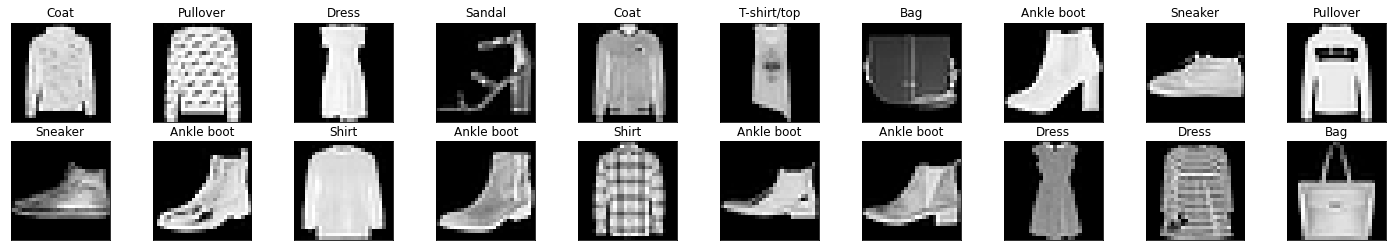

In [3]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()


# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(classes[labels[idx]])

We will use the images in the training dataset as the basis for training a Generative Adversarial Network.

Specifically, the generator model will learn how to generate new plausible items of clothing using a discriminator that will try to distinguish between real images from the Fashion MNIST training dataset and new images output by the generator model.

# Conditional GAN for Fashion-MNIST

In this section, we will develop a conditional GAN for the Fashion-MNIST dataset.

In [4]:
import argparse
# TODO: you can tune the Hyperparameters as you need
parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=200,
                    help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=64,
                    help="size of the batches")
parser.add_argument("--lr", type=float, default=0.0002,
                    help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.5,
                    help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999,
                    help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=8,
                    help="number of cpu threads to use during batch generation")
parser.add_argument("--label_dim", type=int, default=50,
                    help="dimensionality of the label embedding")
parser.add_argument("--latent_dim", type=int, default=100,
                    help="dimensionality of the noise embedding")
parser.add_argument("--n_classes", type=int, default=10,
                    help="number of classes for dataset")
parser.add_argument("--img_size", type=int, default=28,
                    help="size of each image dimension")
parser.add_argument("--channels", type=int, default=1,
                    help="number of image channels")

opt = parser.parse_args(args=[])
print(opt)
img_shape = (opt.channels, opt.img_size, opt.img_size)

cuda = True if torch.cuda.is_available() else False

Namespace(b1=0.5, b2=0.999, batch_size=64, channels=1, img_size=28, label_dim=50, latent_dim=100, lr=0.0002, n_classes=10, n_cpu=8, n_epochs=200)


The generator model has two inputs: a point in the latent space and an integer for the class label of the image, outputs a single 28×28 grayscale image.

In [5]:
# 参考代码：https://zhuanlan.zhihu.com/p/72279816
import torch.nn as nn
import torch.nn.functional as F


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.label_embedding = nn.Embedding(opt.n_classes, opt.label_dim)
        # TODO: There are many ways to implement the model,  one alternative
        # architecture is (100+50)--->128--->256--->512--->1024--->(1,28,28)

        def block(input_feat, output_feat, normalize=True):
            '''Linear->BN->ReLU'''
            layers = [nn.Linear(input_feat, output_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(output_feat, 0.8))
            layers.append(nn.ReLU(True))
            return layers

        # blocks->Linear->Tanh
        self.model = nn.Sequential(
            *block(opt.latent_dim + opt.label_dim, 128, False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, noise, labels):

        labels = self.label_embedding(labels)
        img = self.model(torch.cat((noise, labels), -1))
        img = img.contiguous().view(img.size(0), *img_shape)

        return img

The discriminator model has two inputs: a real image or a generated image and the same class label, outputs a classification of real or fake.

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.label_embedding = nn.Embedding(opt.n_classes, opt.label_dim)
        # TODO: There are many ways to implement the discriminator,  one alternative
        # architecture is (50+784)--->512--->512--->512--->1

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)) + opt.label_dim, 512),
            nn.LeakyReLU(0.2, True),
            nn.Linear(512, 512),
            nn.LeakyReLU(0.2, True),
            nn.Linear(512, 512),
            nn.Sigmoid()
        )

    def forward(self, img, labels):

        labels = self.label_embedding(labels)
        img = img.view(img.size(0), -1)
        D_input = torch.cat((img, labels), -1).contiguous()
        validity = self.model(D_input)

        return validity

In [7]:
import os

# Loss functions
adversarial_loss = torch.nn.MSELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

# Configure data loader
dataloader = torch.utils.data.DataLoader(
    FashionMNIST(root='./data',
                 train=True,
                 download=False,
                 transform=transforms.Compose([
                     transforms.Resize(opt.img_size), 
                     transforms.ToTensor(),
                     transforms.Normalize([0.5], [0.5])
                    ]),
                ),
    batch_size=opt.batch_size,
    shuffle=True,
)

# Optimizers
optimizer_G = torch.optim.Adam(
    generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(
    discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

In [8]:
for i, (imgs, labels) in enumerate(dataloader):
    if i % 100 == 0:
        print("[Batch %d/%d]" % (i, len(dataloader)))
        print("imgs.shape:", imgs.shape)
        print("labels.shape:", labels.shape)

[Batch 0/938]
imgs.shape: torch.Size([64, 1, 28, 28])
labels.shape: torch.Size([64])
[Batch 100/938]
imgs.shape: torch.Size([64, 1, 28, 28])
labels.shape: torch.Size([64])
[Batch 200/938]
imgs.shape: torch.Size([64, 1, 28, 28])
labels.shape: torch.Size([64])
[Batch 300/938]
imgs.shape: torch.Size([64, 1, 28, 28])
labels.shape: torch.Size([64])
[Batch 400/938]
imgs.shape: torch.Size([64, 1, 28, 28])
labels.shape: torch.Size([64])
[Batch 500/938]
imgs.shape: torch.Size([64, 1, 28, 28])
labels.shape: torch.Size([64])
[Batch 600/938]
imgs.shape: torch.Size([64, 1, 28, 28])
labels.shape: torch.Size([64])
[Batch 700/938]
imgs.shape: torch.Size([64, 1, 28, 28])
labels.shape: torch.Size([64])
[Batch 800/938]
imgs.shape: torch.Size([64, 1, 28, 28])
labels.shape: torch.Size([64])
[Batch 900/938]
imgs.shape: torch.Size([64, 1, 28, 28])
labels.shape: torch.Size([64])


First, the discriminator model is updated for a half batch of real samples, then a half batch of fake samples, together forming one batch of weight updates. The generator is then updated via the composite gan model. Importantly, the class label is set to 1 or real for the fake samples. This has the effect of updating the generator toward getting better at generating real samples on the next batch.

The generator model is saved at the end of training.

This model can be loaded and used to generate new random but plausible samples from the fashion MNIST dataset.

In [9]:
# TODO: implement the training process

for epoch in range(opt.n_epochs):
    for i, (imgs, labels) in enumerate(dataloader):

        batch_size = imgs.shape[0]

        # Adversarial ground truths
        valid = FloatTensor(batch_size, 1).fill_(1.0)
        fake = FloatTensor(batch_size, 1).fill_(0.0)

        # Configure input
        real_imgs = imgs.type(FloatTensor)
        labels = labels.type(LongTensor)

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input.
        noise = FloatTensor(np.random.normal(0, 1, (batch_size, opt.latent_dim)))

        # Generate a batch of images.
        g_imgs = generator(noise, labels)

        # Loss measures generator's ability to fool the discriminator.
        g_loss = adversarial_loss(discriminator(g_imgs, labels), valid)
        g_loss.backward()

        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples.
        real_loss = adversarial_loss(discriminator(real_imgs, labels), valid)
        fake_loss = adversarial_loss(discriminator(g_imgs.detach(), labels), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()

        optimizer_D.step()

        if i % 100 == 0:
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, opt.n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
            )
    if (epoch+1) % 20 == 0:
        torch.save(generator.state_dict(), "./cgan_generator %d.pth" % (epoch + 1))

/home/liyang/anaconda3/envs/liyang-env-py3/lib/python3.6/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64, 512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch 0/200] [Batch 0/938] [D loss: 0.249493] [G loss: 0.249483]
[Epoch 0/200] [Batch 100/938] [D loss: 0.181954] [G loss: 0.305087]
[Epoch 0/200] [Batch 200/938] [D loss: 0.094944] [G loss: 0.545496]
[Epoch 0/200] [Batch 300/938] [D loss: 0.063244] [G loss: 0.596357]
[Epoch 0/200] [Batch 400/938] [D loss: 0.111688] [G loss: 0.843052]
[Epoch 0/200] [Batch 500/938] [D loss: 0.055819] [G loss: 0.620865]
[Epoch 0/200] [Batch 600/938] [D loss: 0.078383] [G loss: 0.757964]
[Epoch 0/200] [Batch 700/938] [D loss: 0.127470] [G loss: 0.573411]
[Epoch 0/200] [Batch 800/938] [D loss: 0.122360] [G loss: 0.613256]
[Epoch 0/200] [Batch 900/938] [D loss: 0.099953] [G loss: 0.530030]


/home/liyang/anaconda3/envs/liyang-env-py3/lib/python3.6/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch 1/200] [Batch 0/938] [D loss: 0.143963] [G loss: 0.896613]
[Epoch 1/200] [Batch 100/938] [D loss: 0.111707] [G loss: 0.672774]
[Epoch 1/200] [Batch 200/938] [D loss: 0.099690] [G loss: 0.550241]
[Epoch 1/200] [Batch 300/938] [D loss: 0.186507] [G loss: 0.896756]
[Epoch 1/200] [Batch 400/938] [D loss: 0.143861] [G loss: 0.460920]
[Epoch 1/200] [Batch 500/938] [D loss: 0.097886] [G loss: 0.399200]
[Epoch 1/200] [Batch 600/938] [D loss: 0.162295] [G loss: 0.496668]
[Epoch 1/200] [Batch 700/938] [D loss: 0.192559] [G loss: 0.312819]
[Epoch 1/200] [Batch 800/938] [D loss: 0.185345] [G loss: 0.327088]
[Epoch 1/200] [Batch 900/938] [D loss: 0.184215] [G loss: 0.305785]
[Epoch 2/200] [Batch 0/938] [D loss: 0.214452] [G loss: 0.499561]
[Epoch 2/200] [Batch 100/938] [D loss: 0.174270] [G loss: 0.327460]
[Epoch 2/200] [Batch 200/938] [D loss: 0.196590] [G loss: 0.602197]
[Epoch 2/200] [Batch 300/938] [D loss: 0.265567] [G loss: 0.721173]
[Epoch 2/200] [Batch 400/938] [D loss: 0.171824] [G 

Running the example loads the saved conditional GAN model and uses it to generate 100 items of clothing.

The clothing is organized in columns. From left to right, they are “t-shirt“, ‘trouser‘, ‘pullover‘, ‘dress‘, ‘coat‘, ‘sandal‘, ‘shirt‘, ‘sneaker‘, ‘bag‘, and ‘ankle boot‘.

We can see not only are the randomly generated items of clothing plausible, but they also match their expected category.

torch.Size([100, 100])
torch.Size([100])


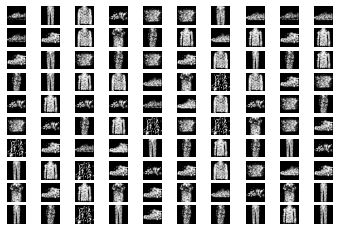

In [15]:
# TODO:example of loading the generator model and generating images
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from matplotlib import pyplot


# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes):
    # Sample noise
    z = FloatTensor(randn(n_samples, latent_dim))
    labels = LongTensor(randint(n_classes, size=n_samples))

    return z, labels


# create and save a plot of generated images
def save_plot(examples, n):
    # plot images
    for i in range(n * n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(np.squeeze(examples[i, :, :]), cmap='gray')
    pyplot.show()


# # load model
generator = Generator()
generator.cuda()
generator.load_state_dict(torch.load('./cgan_generator 180.pth'))
generator.eval()


z, labels = generate_latent_points(100, 100, 10)
print(z.shape)
print(labels.shape)

X = generator(z, labels).cpu().detach()
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
save_plot(X, 10)